# Demo of the GTM on 2-Dimensional Joe-Copula

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 2 dimensional Joe copula.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv

# Other Stuff
import numpy as np
import torch
from torch.utils.data import DataLoader
from dataset_helpers import Generic_Dataset

/Users/franciscocapunay/miniforge3/envs/gtm-general/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a Joe Copula and add Gaussian marginals. Feel free to exchange the copula parameter, the rotation or even the copula itsself.
The list of copulas can be found with `help(pv.Bicop)`.

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [2]:
copula_pv = pv.Bicop(family=pv.BicopFamily.joe, parameters=np.array([[2.5]]), rotation=90)

# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [3]:
loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = torch.tensor(loglik_copula) + log_marginals

/var/folders/_p/ttn2qcdj23jdpltyffhwq9pr0000gn/T/ipykernel_46078/2085715786.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/var/folders/_p/ttn2qcdj23jdpltyffhwq9pr0000gn/T/ipykernel_46078/2085715786.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/var/folders/_p/ttn2qcdj23jdpltyffhwq9pr0000gn/T/ipykernel_46078/2085715786.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [4]:
copula_pv_est = pv.Bicop(family=pv.BicopFamily.joe, rotation=90)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

In [5]:
loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = torch.tensor(loglik_copula) + log_marginals

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [6]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [7]:
model = GTM(
    number_variables = 2,
    number_transformation_layers = 1,
    number_decorrelation_layers = 3,
    degree_transformations = 10,
    degree_decorrelation = 40,
    spline_transformation = "bspline",
    spline_decorrelation = "bspline",
    transformation_spline_range = (-10, 10),
    device = "cpu") 

The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

In [8]:
#model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

In [9]:
#model.plot_marginals(simulated_data_train)

### 3. Hyperparameter Tune and Train Model

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [10]:
study = model.hyperparameter_tune_penalties( 
        train_dataloader = dataloader_train,
        validate_dataloader = dataloader_validate,
        penalty_decorrelation_ridge_param = None,
        penalty_decorrelation_ridge_first_difference = "sample",
        penalty_decorrelation_ridge_second_difference = "sample",
        penalty_transformation_ridge_second_difference = None,
        penalty_lasso_conditional_independence = None,
        adaptive_lasso_weights_matrix=False,
        optimizer="LBFGS",
        learning_rate=1,
        iterations=2000,
        patience=5,
        min_delta=1e-7,
        seperate_copula_training=False,
        max_batches_per_iter=False,
        pretrained_transformation_layer=True,
        n_trials=30,
        temp_folder=".",
        study_name=None)
        

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            study.best_params["penalty_decorrelation_ridge_first_difference"],
                            study.best_params["penalty_decorrelation_ridge_second_difference"],
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False

/Users/franciscocapunay/miniforge3/envs/gtm-general/lib/python3.11/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-10-07 21:37:15,818] A new study created in RDB with name: no-name-a86c11b3-b46c-4c86-ba4c-5f5b1da58f5c
  0%|          | 0/2000 [00:00<?, ?it/s]/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:595: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.

current_loss: tensor(1.4209, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3872, grad_fn=<MeanBackward0>)
current_loss_val:  1.3718489408493042
current_loss: tensor(1.3872, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3411, grad_fn=<MeanBackward0>)
current_loss_val:  1.305450201034546
current_loss: tensor(1.3411, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3244, grad_fn=<MeanBackward0>)
current_loss_val:  1.2892543077468872
current_loss: tensor(1.3244, grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:09, 15.36it/s]

current_loss: tensor(1.3146, grad_fn=<MeanBackward0>)
current_loss_val:  1.2843601703643799
current_loss: tensor(1.3146, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3080, grad_fn=<MeanBackward0>)
current_loss_val:  1.2797833681106567
current_loss: tensor(1.3080, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3046, grad_fn=<MeanBackward0>)
current_loss_val:  1.276521921157837
current_loss: tensor(1.3046, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3020, grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:04, 15.98it/s]

current_loss_val:  1.2739992141723633
current_loss: tensor(1.3020, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2999, grad_fn=<MeanBackward0>)
current_loss_val:  1.2715325355529785
current_loss: tensor(1.2999, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2961, grad_fn=<MeanBackward0>)
current_loss_val:  1.2651928663253784
current_loss: tensor(1.2961, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2936, grad_fn=<MeanBackward0>)
current_loss_val:  1.2587428092956543


  1%|          | 12/2000 [00:00<02:15, 14.70it/s]

current_loss: tensor(1.2936, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2902, grad_fn=<MeanBackward0>)
current_loss_val:  1.2574740648269653
current_loss: tensor(1.2902, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2875, grad_fn=<MeanBackward0>)
current_loss_val:  1.255517601966858
current_loss: tensor(1.2875, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2840, grad_fn=<MeanBackward0>)
current_loss_val:  1.252561092376709


  1%|          | 14/2000 [00:00<02:18, 14.31it/s]

current_loss: tensor(1.2840, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2875, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2821, grad_fn=<MeanBackward0>)
current_loss_val:  1.2508522272109985
current_loss: tensor(1.2821, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2807, grad_fn=<MeanBackward0>)
current_loss_val:  1.2499167919158936
current_loss: tensor(1.2807, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2779, grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:21, 14.05it/s]

current_loss_val:  1.2473241090774536
current_loss: tensor(1.2779, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2784, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2772, grad_fn=<MeanBackward0>)
current_loss_val:  1.2468633651733398
current_loss: tensor(1.2772, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2767, grad_fn=<MeanBackward0>)
current_loss_val:  1.246734857559204
current_loss: tensor(1.2767, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2754, grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:26, 13.55it/s]

current_loss_val:  1.246585488319397
current_loss: tensor(1.2754, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2757, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2750, grad_fn=<MeanBackward0>)
current_loss_val:  1.24655020236969
current_loss: tensor(1.2750, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2747, grad_fn=<MeanBackward0>)
current_loss_val:  1.2464652061462402
current_loss: tensor(1.2747, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2734, grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:20, 14.07it/s]

current_loss_val:  1.2458852529525757
current_loss: tensor(1.2734, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2730, grad_fn=<MeanBackward0>)
current_loss_val:  1.245251178741455
current_loss: tensor(1.2730, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2723, grad_fn=<MeanBackward0>)
current_loss_val:  1.2451655864715576
current_loss: tensor(1.2723, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2720, grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:01<02:09, 15.18it/s]

current_loss_val:  1.2450532913208008
current_loss: tensor(1.2720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2715, grad_fn=<MeanBackward0>)
current_loss_val:  1.244779109954834
current_loss: tensor(1.2715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2710, grad_fn=<MeanBackward0>)
current_loss_val:  1.2442619800567627
current_loss: tensor(1.2710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2706, grad_fn=<MeanBackward0>)
current_loss_val:  1.2439426183700562


  2%|▏         | 30/2000 [00:02<02:06, 15.56it/s]

current_loss: tensor(1.2706, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2702, grad_fn=<MeanBackward0>)
current_loss_val:  1.2433583736419678
current_loss: tensor(1.2702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2696, grad_fn=<MeanBackward0>)
current_loss_val:  1.2426724433898926
current_loss: tensor(1.2696, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2689, grad_fn=<MeanBackward0>)
current_loss_val:  1.2420971393585205
current_loss: tensor(1.2689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2683, grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:02<02:01, 16.13it/s]

current_loss_val:  1.2416657209396362
current_loss: tensor(1.2683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2680, grad_fn=<MeanBackward0>)
current_loss_val:  1.2414182424545288
current_loss: tensor(1.2680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2678, grad_fn=<MeanBackward0>)
current_loss_val:  1.2414345741271973
current_loss: tensor(1.2678, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2675, grad_fn=<MeanBackward0>)
current_loss_val:  1.24143648147583
current_loss: tensor(1.2675, grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:02<02:03, 15.85it/s]

current_loss: tensor(1.2672, grad_fn=<MeanBackward0>)
current_loss_val:  1.241392731666565
current_loss: tensor(1.2672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2669, grad_fn=<MeanBackward0>)
current_loss_val:  1.2413066625595093
current_loss: tensor(1.2669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2667, grad_fn=<MeanBackward0>)
current_loss_val:  1.2413315773010254
current_loss: tensor(1.2667, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2664, grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:02<02:03, 15.86it/s]

current_loss_val:  1.241502046585083
current_loss: tensor(1.2664, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2668, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2664, grad_fn=<MeanBackward0>)
current_loss_val:  1.2415220737457275
current_loss: tensor(1.2664, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2663, grad_fn=<MeanBackward0>)
current_loss_val:  1.2414902448654175
current_loss: tensor(1.2663, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2660, grad_fn=<MeanBackward0>)
current_loss_val:  1.2410756349563599


  2%|▏         | 44/2000 [00:02<02:00, 16.19it/s]

current_loss: tensor(1.2660, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2658, grad_fn=<MeanBackward0>)
current_loss_val:  1.24065363407135
current_loss: tensor(1.2658, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2656, grad_fn=<MeanBackward0>)
current_loss_val:  1.2405006885528564
current_loss: tensor(1.2656, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2652, grad_fn=<MeanBackward0>)
current_loss_val:  1.2401376962661743
current_loss: tensor(1.2652, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2648, grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:03<01:57, 16.54it/s]

current_loss_val:  1.2396403551101685
current_loss: tensor(1.2648, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2644, grad_fn=<MeanBackward0>)
current_loss_val:  1.2373433113098145
current_loss: tensor(1.2644, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2632, grad_fn=<MeanBackward0>)
current_loss_val:  1.2373037338256836
current_loss: tensor(1.2632, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2629, grad_fn=<MeanBackward0>)
current_loss_val:  1.237255334854126
current_loss: tensor(1.2629, grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:03<02:04, 15.62it/s]

current_loss: tensor(1.2624, grad_fn=<MeanBackward0>)
current_loss_val:  1.2371071577072144
current_loss: tensor(1.2624, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2623, grad_fn=<MeanBackward0>)
current_loss_val:  1.2368625402450562
current_loss: tensor(1.2623, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2621, grad_fn=<MeanBackward0>)
current_loss_val:  1.2367885112762451
current_loss: tensor(1.2621, grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:03<02:03, 15.82it/s]

current_loss: tensor(1.2619, grad_fn=<MeanBackward0>)
current_loss_val:  1.2366524934768677
current_loss: tensor(1.2619, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2617, grad_fn=<MeanBackward0>)
current_loss_val:  1.2364362478256226
current_loss: tensor(1.2617, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2616, grad_fn=<MeanBackward0>)
current_loss_val:  1.2362079620361328
current_loss: tensor(1.2616, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2615, grad_fn=<MeanBackward0>)


  3%|▎         | 58/2000 [00:03<02:01, 15.97it/s]

current_loss_val:  1.2362241744995117
current_loss: tensor(1.2615, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2615, grad_fn=<MeanBackward0>)
current_loss_val:  1.2362236976623535
current_loss: tensor(1.2615, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2614, grad_fn=<MeanBackward0>)
current_loss_val:  1.236215591430664
current_loss: tensor(1.2614, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2613, grad_fn=<MeanBackward0>)
current_loss_val:  1.2361968755722046
current_loss: tensor(1.2613, grad_fn=<MeanBackward0>)


  3%|▎         | 62/2000 [00:04<01:57, 16.47it/s]

current_loss: tensor(1.2611, grad_fn=<MeanBackward0>)
current_loss_val:  1.236145257949829
current_loss: tensor(1.2611, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2609, grad_fn=<MeanBackward0>)
current_loss_val:  1.2360745668411255
current_loss: tensor(1.2609, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2607, grad_fn=<MeanBackward0>)
current_loss_val:  1.2359737157821655
current_loss: tensor(1.2607, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2604, grad_fn=<MeanBackward0>)


  3%|▎         | 66/2000 [00:04<02:23, 13.52it/s]

current_loss_val:  1.235924482345581
current_loss: tensor(1.2604, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2600, grad_fn=<MeanBackward0>)
current_loss_val:  1.2358901500701904
current_loss: tensor(1.2600, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2594, grad_fn=<MeanBackward0>)
current_loss_val:  1.2359824180603027
current_loss: tensor(1.2594, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2593, grad_fn=<MeanBackward0>)
current_loss_val:  1.2361818552017212
current_loss: tensor(1.2593, grad_fn=<MeanBackward0>)


  3%|▎         | 68/2000 [00:04<02:15, 14.27it/s]

current_loss: tensor(1.2589, grad_fn=<MeanBackward0>)
current_loss_val:  1.2359569072723389
current_loss: tensor(1.2589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2587, grad_fn=<MeanBackward0>)
current_loss_val:  1.2357163429260254
current_loss: tensor(1.2587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2584, grad_fn=<MeanBackward0>)
current_loss_val:  1.2351114749908447
current_loss: tensor(1.2584, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2582, grad_fn=<MeanBackward0>)


  4%|▎         | 72/2000 [00:04<02:09, 14.89it/s]

current_loss_val:  1.2347643375396729
current_loss: tensor(1.2582, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2581, grad_fn=<MeanBackward0>)
current_loss_val:  1.2344939708709717
current_loss: tensor(1.2581, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2580, grad_fn=<MeanBackward0>)
current_loss_val:  1.2341501712799072
current_loss: tensor(1.2580, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2579, grad_fn=<MeanBackward0>)
current_loss_val:  1.2337114810943604
current_loss: tensor(1.2579, grad_fn=<MeanBackward0>)


  4%|▍         | 76/2000 [00:04<02:01, 15.89it/s]

current_loss: tensor(1.2579, grad_fn=<MeanBackward0>)
current_loss_val:  1.2337329387664795
current_loss: tensor(1.2579, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2579, grad_fn=<MeanBackward0>)
current_loss_val:  1.2337257862091064
current_loss: tensor(1.2579, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2578, grad_fn=<MeanBackward0>)
current_loss_val:  1.2336337566375732
current_loss: tensor(1.2578, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2576, grad_fn=<MeanBackward0>)
current_loss_val:  1.2333767414093018


  4%|▍         | 78/2000 [00:05<02:03, 15.54it/s]

current_loss: tensor(1.2576, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2577, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2574, grad_fn=<MeanBackward0>)
current_loss_val:  1.2330389022827148
current_loss: tensor(1.2574, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2572, grad_fn=<MeanBackward0>)
current_loss_val:  1.2328159809112549
current_loss: tensor(1.2572, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2569, grad_fn=<MeanBackward0>)


  4%|▍         | 82/2000 [00:05<03:27,  9.27it/s]

current_loss_val:  1.2321404218673706
current_loss: tensor(1.2569, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2564, grad_fn=<MeanBackward0>)
current_loss_val:  1.2309318780899048
current_loss: tensor(1.2564, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2559, grad_fn=<MeanBackward0>)
current_loss_val:  1.229664921760559


  4%|▍         | 84/2000 [00:05<02:59, 10.68it/s]

current_loss: tensor(1.2559, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2554, grad_fn=<MeanBackward0>)
current_loss_val:  1.2292366027832031
current_loss: tensor(1.2554, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2552, grad_fn=<MeanBackward0>)
current_loss_val:  1.229059100151062
current_loss: tensor(1.2552, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2547, grad_fn=<MeanBackward0>)
current_loss_val:  1.2284880876541138
current_loss: tensor(1.2547, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2549, grad_fn=<MeanBackward0>)


  4%|▍         | 88/2000 [00:06<02:33, 12.47it/s]

current_loss: tensor(1.2546, grad_fn=<MeanBackward0>)
current_loss_val:  1.22841477394104
current_loss: tensor(1.2546, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2544, grad_fn=<MeanBackward0>)
current_loss_val:  1.228366732597351
current_loss: tensor(1.2544, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2541, grad_fn=<MeanBackward0>)
current_loss_val:  1.2282239198684692
current_loss: tensor(1.2541, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2539, grad_fn=<MeanBackward0>)


  5%|▍         | 92/2000 [00:06<02:14, 14.20it/s]

current_loss_val:  1.2281678915023804
current_loss: tensor(1.2539, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2537, grad_fn=<MeanBackward0>)
current_loss_val:  1.2281794548034668
current_loss: tensor(1.2537, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2536, grad_fn=<MeanBackward0>)
current_loss_val:  1.2282072305679321
current_loss: tensor(1.2536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2532, grad_fn=<MeanBackward0>)
current_loss_val:  1.228453516960144


  5%|▍         | 93/2000 [00:06<02:14, 14.19it/s]
[I 2025-10-07 21:37:24,215] Trial 0 finished with value: -2.4563355445861816 and parameters: {'penalty_decorrelation_ridge_first_difference': 5.811554828200286, 'penalty_decorrelation_ridge_second_difference': 22.91255541746725}. Best is trial 0 with value: -2.4563355445861816.


current_loss: tensor(1.2532, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2530, grad_fn=<MeanBackward0>)
current_loss_val:  1.2286473512649536
current_loss: tensor(1.2530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2529, grad_fn=<MeanBackward0>)
current_loss_val:  1.228745698928833
Early Stop at iteration 93 with minimal loss tensor(1.2282) and patience 5 and min_delta 1e-07


  0%|          | 2/2000 [00:00<02:06, 15.76it/s]

current_loss: tensor(1.2656, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2649, grad_fn=<MeanBackward0>)
current_loss_val:  1.2283170223236084
current_loss: tensor(1.2649, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2641, grad_fn=<MeanBackward0>)
current_loss_val:  1.2292460203170776
current_loss: tensor(1.2641, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2631, grad_fn=<MeanBackward0>)
current_loss_val:  1.2296090126037598
current_loss: tensor(1.2631, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2629, grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<02:26, 13.63it/s]
[I 2025-10-07 21:37:24,679] Trial 1 finished with value: -2.456634283065796 and parameters: {'penalty_decorrelation_ridge_first_difference': 17.332838970942376, 'penalty_decorrelation_ridge_second_difference': 2.200210444993283}. Best is trial 0 with value: -2.4563355445861816.


current_loss_val:  1.2294659614562988
current_loss: tensor(1.2629, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2624, grad_fn=<MeanBackward0>)
current_loss_val:  1.2292917966842651
current_loss: tensor(1.2624, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2622, grad_fn=<MeanBackward0>)
current_loss_val:  1.2295119762420654
Early Stop at iteration 5 with minimal loss tensor(1.2283) and patience 5 and min_delta 1e-07


  0%|          | 2/2000 [00:00<02:22, 13.98it/s]

current_loss: tensor(1.2797, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2818, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2790, grad_fn=<MeanBackward0>)
current_loss_val:  1.228261113166809
current_loss: tensor(1.2790, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2782, grad_fn=<MeanBackward0>)
current_loss_val:  1.2283607721328735
current_loss: tensor(1.2782, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2749, grad_fn=<MeanBackward0>)
current_loss_val:  1.2299041748046875
current_loss: tensor(1.2749, grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<02:40, 12.40it/s]

current_loss: tensor(1.2764, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2743, grad_fn=<MeanBackward0>)
current_loss_val:  1.230280876159668
current_loss: tensor(1.2743, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2738, grad_fn=<MeanBackward0>)
current_loss_val:  1.2304291725158691
current_loss: tensor(1.2738, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2720, grad_fn=<MeanBackward0>)
current_loss_val:  1.231441855430603
Early Stop at iteration 5 with minimal loss tensor(1.2283) and patience 5 and min_delta 1e-07



[I 2025-10-07 21:37:25,180] Trial 2 finished with value: -2.456521987915039 and parameters: {'penalty_decorrelation_ridge_first_difference': 27.868621171899022, 'penalty_decorrelation_ridge_second_difference': 29.607813269148302}. Best is trial 0 with value: -2.4563355445861816.
  0%|          | 2/2000 [00:00<02:14, 14.87it/s]

current_loss: tensor(1.2703, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2698, grad_fn=<MeanBackward0>)
current_loss_val:  1.2282557487487793
current_loss: tensor(1.2698, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2693, grad_fn=<MeanBackward0>)
current_loss_val:  1.2283321619033813
current_loss: tensor(1.2693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2673, grad_fn=<MeanBackward0>)
current_loss_val:  1.2296092510223389
current_loss: tensor(1.2673, grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<02:38, 12.60it/s]

current_loss: tensor(1.2685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2669, grad_fn=<MeanBackward0>)
current_loss_val:  1.229874610900879
current_loss: tensor(1.2669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2666, grad_fn=<MeanBackward0>)
current_loss_val:  1.2299450635910034
current_loss: tensor(1.2666, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2656, grad_fn=<MeanBackward0>)
current_loss_val:  1.2303911447525024
Early Stop at iteration 5 with minimal loss tensor(1.2283) and patience 5 and min_delta 1e-07



[I 2025-10-07 21:37:25,677] Trial 3 finished with value: -2.4565112590789795 and parameters: {'penalty_decorrelation_ridge_first_difference': 20.228657218464832, 'penalty_decorrelation_ridge_second_difference': 21.013381549079558}. Best is trial 0 with value: -2.4563355445861816.
  0%|          | 2/2000 [00:00<01:56, 17.08it/s]

current_loss: tensor(1.2567, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2567, grad_fn=<MeanBackward0>)
current_loss_val:  1.2282459735870361
current_loss: tensor(1.2567, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2564, grad_fn=<MeanBackward0>)
current_loss_val:  1.228198766708374
current_loss: tensor(1.2564, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2563, grad_fn=<MeanBackward0>)
current_loss_val:  1.228216290473938
current_loss: tensor(1.2563, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2562, grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:25, 13.66it/s]

current_loss_val:  1.2282298803329468
current_loss: tensor(1.2562, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2557, grad_fn=<MeanBackward0>)
current_loss_val:  1.2284250259399414
current_loss: tensor(1.2557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2579, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2555, grad_fn=<MeanBackward0>)
current_loss_val:  1.2285549640655518
current_loss: tensor(1.2555, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2554, grad_fn=<MeanBackward0>)
current_loss_val:  1.228621006011963
Early Stop at iteration 6 with minimal loss tensor(1.2282) and patience 5 and min_delta 1e-07



[I 2025-10-07 21:37:26,226] Trial 4 finished with value: -2.456397533416748 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.84115999755944, 'penalty_decorrelation_ridge_second_difference': 14.013259913538358}. Best is trial 0 with value: -2.4563355445861816.
  0%|          | 1/2000 [00:00<03:33,  9.34it/s]

current_loss: tensor(1.2743, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2760, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2738, grad_fn=<MeanBackward0>)
current_loss_val:  1.228242039680481
current_loss: tensor(1.2738, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2732, grad_fn=<MeanBackward0>)
current_loss_val:  1.2283170223236084
current_loss: tensor(1.2732, grad_fn=<MeanBackward0>)
current_loss: 

  0%|          | 5/2000 [00:00<02:30, 13.24it/s]

tensor(1.2706, grad_fn=<MeanBackward0>)
current_loss_val:  1.2295902967453003
current_loss: tensor(1.2706, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2721, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2702, grad_fn=<MeanBackward0>)
current_loss_val:  1.2298917770385742
current_loss: tensor(1.2702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2698, grad_fn=<MeanBackward0>)
current_loss_val:  1.230007529258728
current_loss: tensor(1.2698, grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:07, 10.63it/s]
[I 2025-10-07 21:37:26,794] Trial 5 finished with value: -2.456484079360962 and parameters: {'penalty_decorrelation_ridge_first_difference': 23.252021468139077, 'penalty_decorrelation_ridge_second_difference': 27.898600532976328}. Best is trial 0 with value: -2.4563355445861816.


current_loss: tensor(1.2685, grad_fn=<MeanBackward0>)
current_loss_val:  1.2307753562927246
Early Stop at iteration 5 with minimal loss tensor(1.2282) and patience 5 and min_delta 1e-07


  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2789, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2770, grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<02:30, 13.26it/s]

current_loss_val:  1.228456735610962
current_loss: tensor(1.2770, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2741, grad_fn=<MeanBackward0>)
current_loss_val:  1.230747103691101
current_loss: tensor(1.2741, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2735, grad_fn=<MeanBackward0>)
current_loss_val:  1.233643651008606
current_loss: tensor(1.2735, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2721, grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<02:47, 11.89it/s]

current_loss_val:  1.2314355373382568
current_loss: tensor(1.2721, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2717, grad_fn=<MeanBackward0>)
current_loss_val:  1.231044888496399
current_loss: tensor(1.2717, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2712, grad_fn=<MeanBackward0>)
current_loss_val:  1.2305893898010254
Early Stop at iteration 5 with minimal loss tensor(1.2285) and patience 5 and min_delta 1e-07



[I 2025-10-07 21:37:27,330] Trial 6 finished with value: -2.456913471221924 and parameters: {'penalty_decorrelation_ridge_first_difference': 28.95504335496653, 'penalty_decorrelation_ridge_second_difference': 1.457591944976694}. Best is trial 0 with value: -2.4563355445861816.
  0%|          | 2/2000 [00:00<02:34, 12.90it/s]

current_loss: tensor(1.2509, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2519, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2508, grad_fn=<MeanBackward0>)
current_loss_val:  1.2281737327575684
current_loss: tensor(1.2508, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2507, grad_fn=<MeanBackward0>)
current_loss_val:  1.2281715869903564
current_loss: tensor(1.2507, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2504, grad_fn=<MeanBackward0>)
current_loss_val:  1.2281713485717773


  0%|          | 6/2000 [00:00<02:09, 15.45it/s]

current_loss: tensor(1.2504, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2503, grad_fn=<MeanBackward0>)
current_loss_val:  1.228258490562439
current_loss: tensor(1.2503, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2502, grad_fn=<MeanBackward0>)
current_loss_val:  1.2282296419143677
current_loss: tensor(1.2502, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2502, grad_fn=<MeanBackward0>)
current_loss_val:  1.2282270193099976
current_loss: tensor(1.2502, grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<02:31, 13.13it/s]
[I 2025-10-07 21:37:27,973] Trial 7 finished with value: -2.4563426971435547 and parameters: {'penalty_decorrelation_ridge_first_difference': 3.0608962445826475, 'penalty_decorrelation_ridge_second_difference': 24.710970237188125}. Best is trial 0 with value: -2.4563355445861816.


current_loss: tensor(1.2501, grad_fn=<MeanBackward0>)
current_loss_val:  1.228217601776123
current_loss: tensor(1.2501, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2501, grad_fn=<MeanBackward0>)
current_loss_val:  1.228193998336792
Early Stop at iteration 7 with minimal loss tensor(1.2282) and patience 5 and min_delta 1e-07


  0%|          | 1/2000 [00:00<03:23,  9.81it/s]

current_loss: tensor(1.2596, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2596, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2594, grad_fn=<MeanBackward0>)
current_loss_val:  1.2282136678695679
current_loss: tensor(1.2594, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2592, grad_fn=<MeanBackward0>)
current_loss_val:  1.2282273769378662
current_loss: tensor(1.2592, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2583, grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<02:38, 12.61it/s]

current_loss_val:  1.2289518117904663
current_loss: tensor(1.2583, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2593, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2581, grad_fn=<MeanBackward0>)
current_loss_val:  1.2288646697998047
current_loss: tensor(1.2581, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2580, grad_fn=<MeanBackward0>)
current_loss_val:  1.2289048433303833
current_loss: tensor(1.2580, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2577, grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:08, 10.59it/s]
[I 2025-10-07 21:37:28,549] Trial 8 finished with value: -2.4564273357391357 and parameters: {'penalty_decorrelation_ridge_first_difference': 11.185009934478234, 'penalty_decorrelation_ridge_second_difference': 16.1562237427104}. Best is trial 0 with value: -2.4563355445861816.


current_loss_val:  1.2291007041931152
Early Stop at iteration 5 with minimal loss tensor(1.2282) and patience 5 and min_delta 1e-07


  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2736, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2751, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2731, grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<02:52, 11.61it/s]

current_loss_val:  1.2282418012619019
current_loss: tensor(1.2731, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2726, grad_fn=<MeanBackward0>)
current_loss_val:  1.2283154726028442
current_loss: tensor(1.2726, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2701, grad_fn=<MeanBackward0>)
current_loss_val:  1.2295717000961304
current_loss: tensor(1.2701, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2716, grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:57, 11.26it/s]

current_loss: tensor(1.2696, grad_fn=<MeanBackward0>)
current_loss_val:  1.2298661470413208
current_loss: tensor(1.2696, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2693, grad_fn=<MeanBackward0>)
current_loss_val:  1.2299760580062866
current_loss: tensor(1.2693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2680, grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:31,  9.45it/s]
[I 2025-10-07 21:37:29,215] Trial 9 finished with value: -2.4564836025238037 and parameters: {'penalty_decorrelation_ridge_first_difference': 22.708138675844147, 'penalty_decorrelation_ridge_second_difference': 27.200884345359615}. Best is trial 0 with value: -2.4563355445861816.


current_loss_val:  1.2307076454162598
Early Stop at iteration 5 with minimal loss tensor(1.2282) and patience 5 and min_delta 1e-07


  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2774, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2759, grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<02:40, 12.46it/s]

current_loss_val:  1.2284533977508545
current_loss: tensor(1.2759, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2739, grad_fn=<MeanBackward0>)
current_loss_val:  1.228948712348938
current_loss: tensor(1.2739, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2738, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2722, grad_fn=<MeanBackward0>)
current_loss_val:  1.2302509546279907
current_loss: tensor(1.2722, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2711, grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:42, 12.30it/s]

current_loss_val:  1.230502724647522
current_loss: tensor(1.2711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2701, grad_fn=<MeanBackward0>)
current_loss_val:  1.2315562963485718
current_loss: tensor(1.2701, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2691, grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:11, 10.40it/s]

current_loss_val:  1.234106421470642
Early Stop at iteration 5 with minimal loss tensor(1.2285) and patience 5 and min_delta 1e-07



[I 2025-10-07 21:37:29,809] Trial 10 finished with value: -2.456906795501709 and parameters: {'penalty_decorrelation_ridge_first_difference': 27.123847502636327, 'penalty_decorrelation_ridge_second_difference': 9.967029008970476}. Best is trial 0 with value: -2.4563355445861816.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2699, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2694, grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<02:44, 12.17it/s]

current_loss_val:  1.2282493114471436
current_loss: tensor(1.2694, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2690, grad_fn=<MeanBackward0>)
current_loss_val:  1.2283203601837158
current_loss: tensor(1.2690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2670, grad_fn=<MeanBackward0>)
current_loss_val:  1.2295465469360352
current_loss: tensor(1.2670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2682, grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:44, 12.13it/s]

current_loss: tensor(1.2666, grad_fn=<MeanBackward0>)
current_loss_val:  1.2298038005828857
current_loss: tensor(1.2666, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2663, grad_fn=<MeanBackward0>)
current_loss_val:  1.2298732995986938
current_loss: tensor(1.2663, grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:13, 10.32it/s]

current_loss: tensor(1.2653, grad_fn=<MeanBackward0>)
current_loss_val:  1.2303236722946167
Early Stop at iteration 5 with minimal loss tensor(1.2282) and patience 5 and min_delta 1e-07



[I 2025-10-07 21:37:30,420] Trial 11 finished with value: -2.456498384475708 and parameters: {'penalty_decorrelation_ridge_first_difference': 19.835737038908587, 'penalty_decorrelation_ridge_second_difference': 21.614195593585816}. Best is trial 0 with value: -2.4563355445861816.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2534, grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<03:53,  8.56it/s]

current_loss: tensor(1.2528, grad_fn=<MeanBackward0>)
current_loss_val:  1.228179693222046
current_loss: tensor(1.2528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2528, grad_fn=<MeanBackward0>)
current_loss_val:  1.2281768321990967
current_loss: tensor(1.2528, grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<02:41, 12.34it/s]

current_loss: tensor(1.2524, grad_fn=<MeanBackward0>)
current_loss_val:  1.2282538414001465
current_loss: tensor(1.2524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2522, grad_fn=<MeanBackward0>)
current_loss_val:  1.2282975912094116
current_loss: tensor(1.2522, grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:21,  9.90it/s]

current_loss: tensor(1.2522, grad_fn=<MeanBackward0>)
current_loss_val:  1.2283427715301514
current_loss: tensor(1.2522, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2521, grad_fn=<MeanBackward0>)
current_loss_val:  1.2283587455749512
current_loss: tensor(1.2521, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2520, grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:55,  8.46it/s]

current_loss_val:  1.2286133766174316
Early Stop at iteration 6 with minimal loss tensor(1.2282) and patience 5 and min_delta 1e-07



[I 2025-10-07 21:37:31,257] Trial 12 finished with value: -2.4563536643981934 and parameters: {'penalty_decorrelation_ridge_first_difference': 5.165887545040492, 'penalty_decorrelation_ridge_second_difference': 20.147764959064997}. Best is trial 0 with value: -2.4563355445861816.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2799, grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<03:24,  9.79it/s]

current_loss: tensor(1.2784, grad_fn=<MeanBackward0>)
current_loss_val:  1.228489637374878
current_loss: tensor(1.2784, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2767, grad_fn=<MeanBackward0>)
current_loss_val:  1.2287914752960205
current_loss: tensor(1.2767, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2738, grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<02:43, 12.22it/s]

current_loss_val:  1.2305660247802734


  0%|          | 5/2000 [00:00<02:34, 12.90it/s]

current_loss: tensor(1.2738, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2729, grad_fn=<MeanBackward0>)
current_loss_val:  1.231642246246338
current_loss: tensor(1.2729, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2719, grad_fn=<MeanBackward0>)
current_loss_val:  1.2319917678833008
current_loss: tensor(1.2719, grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:33,  7.29it/s]

current_loss: tensor(1.2707, grad_fn=<MeanBackward0>)
current_loss_val:  1.2328249216079712
Early Stop at iteration 5 with minimal loss tensor(1.2285) and patience 5 and min_delta 1e-07



[I 2025-10-07 21:37:32,274] Trial 13 finished with value: -2.4569790363311768 and parameters: {'penalty_decorrelation_ridge_first_difference': 29.032246668170426, 'penalty_decorrelation_ridge_second_difference': 13.745999388166608}. Best is trial 0 with value: -2.4563355445861816.
  0%|          | 1/2000 [00:00<04:12,  7.91it/s]

current_loss: tensor(1.2616, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2615, grad_fn=<MeanBackward0>)
current_loss_val:  1.2282918691635132
current_loss: tensor(1.2615, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2611, grad_fn=<MeanBackward0>)
current_loss_val:  1.2282606363296509
current_loss: tensor(1.2611, grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:33,  9.33it/s]

current_loss: tensor(1.2609, grad_fn=<MeanBackward0>)
current_loss_val:  1.2282904386520386
current_loss: tensor(1.2609, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2607, grad_fn=<MeanBackward0>)
current_loss_val:  1.2283467054367065
current_loss: tensor(1.2607, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2597, grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:45,  8.84it/s]

current_loss_val:  1.2290202379226685
current_loss: tensor(1.2597, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2602, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2595, grad_fn=<MeanBackward0>)
current_loss_val:  1.229300856590271
current_loss: tensor(1.2595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2593, grad_fn=<MeanBackward0>)
current_loss_val:  1.2294491529464722
Early Stop at iteration 6 with minimal loss tensor(1.2283) and patience 5 and min_delta 1e-07



[I 2025-10-07 21:37:33,092] Trial 14 finished with value: -2.4565212726593018 and parameters: {'penalty_decorrelation_ridge_first_difference': 13.080753119824067, 'penalty_decorrelation_ridge_second_difference': 14.640365309553559}. Best is trial 0 with value: -2.4563355445861816.
  0%|          | 1/2000 [00:00<03:42,  8.99it/s]

current_loss: tensor(1.2519, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2518, grad_fn=<MeanBackward0>)
current_loss_val:  1.2281745672225952
current_loss: tensor(1.2518, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2517, grad_fn=<MeanBackward0>)
current_loss_val:  1.228177785873413
current_loss: tensor(1.2517, grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<02:42, 12.31it/s]

current_loss: tensor(1.2515, grad_fn=<MeanBackward0>)
current_loss_val:  1.2282073497772217
current_loss: tensor(1.2515, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2513, grad_fn=<MeanBackward0>)
current_loss_val:  1.2282909154891968
current_loss: tensor(1.2513, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2513, grad_fn=<MeanBackward0>)
current_loss_val:  1.2283047437667847
current_loss: tensor(1.2513, grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:19, 10.02it/s]
[I 2025-10-07 21:37:33,716] Trial 15 finished with value: -2.4563491344451904 and parameters: {'penalty_decorrelation_ridge_first_difference': 3.6476883263900852, 'penalty_decorrelation_ridge_second_difference': 29.62942170930547}. Best is trial 0 with value: -2.4563355445861816.


current_loss: tensor(1.2512, grad_fn=<MeanBackward0>)
current_loss_val:  1.228298544883728
Early Stop at iteration 5 with minimal loss tensor(1.2282) and patience 5 and min_delta 1e-07


  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2476, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2473, grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<02:36, 12.81it/s]

current_loss_val:  1.228166103363037
current_loss: tensor(1.2473, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2473, grad_fn=<MeanBackward0>)
current_loss_val:  1.228137493133545
current_loss: tensor(1.2473, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2469, grad_fn=<MeanBackward0>)
current_loss_val:  1.2280659675598145
current_loss: tensor(1.2469, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2468, grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:43, 12.17it/s]

current_loss: tensor(1.2467, grad_fn=<MeanBackward0>)
current_loss_val:  1.2279200553894043
current_loss: tensor(1.2467, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2466, grad_fn=<MeanBackward0>)
current_loss_val:  1.228020429611206
current_loss: tensor(1.2466, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2465, grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:22, 13.99it/s]

current_loss_val:  1.2280117273330688
current_loss: tensor(1.2465, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2464, grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:34, 12.87it/s]

current_loss_val:  1.227959394454956
current_loss: tensor(1.2464, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2464, grad_fn=<MeanBackward0>)
current_loss_val:  1.2281728982925415
current_loss: tensor(1.2464, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2463, grad_fn=<MeanBackward0>)
current_loss_val:  1.2279726266860962
Early Stop at iteration 8 with minimal loss tensor(1.2279) and patience 5 and min_delta 1e-07



[I 2025-10-07 21:37:34,432] Trial 16 finished with value: -2.4558403491973877 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.5699358198587818, 'penalty_decorrelation_ridge_second_difference': 17.03644834243672}. Best is trial 16 with value: -2.4558403491973877.
  0%|          | 2/2000 [00:00<01:42, 19.51it/s]

current_loss: tensor(1.2486, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2484, grad_fn=<MeanBackward0>)
current_loss_val:  1.228175401687622
current_loss: tensor(1.2484, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2482, grad_fn=<MeanBackward0>)
current_loss_val:  1.227911353111267
current_loss: tensor(1.2482, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2480, grad_fn=<MeanBackward0>)
current_loss_val:  1.2281323671340942
current_loss: tensor(1.2480, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2479, grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:10, 15.26it/s]

current_loss_val:  1.228040337562561
current_loss: tensor(1.2479, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2478, grad_fn=<MeanBackward0>)
current_loss_val:  1.2279080152511597
current_loss: tensor(1.2478, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2477, grad_fn=<MeanBackward0>)
current_loss_val:  1.227992296218872
current_loss: tensor(1.2477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2477, grad_fn=<MeanBackward0>)
current_loss_val:  1.2279070615768433


  0%|          | 10/2000 [00:00<02:04, 15.95it/s]

current_loss: tensor(1.2477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2476, grad_fn=<MeanBackward0>)
current_loss_val:  1.2278070449829102
current_loss: tensor(1.2476, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2475, grad_fn=<MeanBackward0>)
current_loss_val:  1.2277748584747314
current_loss: tensor(1.2475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2474, grad_fn=<MeanBackward0>)
current_loss_val:  1.2277060747146606
current_loss: tensor(1.2474, grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:00<02:27, 13.50it/s]

current_loss: tensor(1.2473, grad_fn=<MeanBackward0>)
current_loss_val:  1.2279460430145264
current_loss: tensor(1.2473, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2472, grad_fn=<MeanBackward0>)
current_loss_val:  1.227550745010376
current_loss: tensor(1.2472, grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:00<02:36, 12.67it/s]

current_loss: tensor(1.2472, grad_fn=<MeanBackward0>)
current_loss_val:  1.2276158332824707
current_loss: tensor(1.2472, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2472, grad_fn=<MeanBackward0>)
current_loss_val:  1.227627158164978
current_loss: tensor(1.2472, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2472, grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:40, 12.33it/s]

current_loss_val:  1.2275633811950684
current_loss: tensor(1.2472, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2471, grad_fn=<MeanBackward0>)
current_loss_val:  1.2276601791381836
current_loss: tensor(1.2471, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2471, grad_fn=<MeanBackward0>)
current_loss_val:  1.2276219129562378
Early Stop at iteration 16 with minimal loss tensor(1.2276) and patience 5 and min_delta 1e-07



[I 2025-10-07 21:37:35,833] Trial 17 finished with value: -2.455101251602173 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.4972144287940017, 'penalty_decorrelation_ridge_second_difference': 3.2617047769082728}. Best is trial 17 with value: -2.455101251602173.
  0%|          | 2/2000 [00:00<01:55, 17.28it/s]

current_loss: tensor(1.2522, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2520, grad_fn=<MeanBackward0>)
current_loss_val:  1.228201150894165
current_loss: tensor(1.2520, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2517, grad_fn=<MeanBackward0>)
current_loss_val:  1.2280443906784058
current_loss: tensor(1.2517, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2516, grad_fn=<MeanBackward0>)
current_loss_val:  1.2284793853759766
current_loss: tensor(1.2516, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2515, grad_fn=<MeanBackward0>)
current_loss_val:  1.2281720638275146


  0%|          | 7/2000 [00:00<02:06, 15.74it/s]

current_loss: tensor(1.2515, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2514, grad_fn=<MeanBackward0>)
current_loss_val:  1.2281036376953125
current_loss: tensor(1.2514, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2513, grad_fn=<MeanBackward0>)
current_loss_val:  1.2280312776565552
current_loss: tensor(1.2513, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2515, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2512, grad_fn=<MeanBackward0>)
current_loss_val:  1.2281259298324585


  0%|          | 9/2000 [00:00<02:09, 15.37it/s]

current_loss: tensor(1.2512, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2512, grad_fn=<MeanBackward0>)
current_loss_val:  1.22808837890625
current_loss: tensor(1.2512, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2511, grad_fn=<MeanBackward0>)
current_loss_val:  1.2280153036117554
current_loss: tensor(1.2511, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2511, grad_fn=<MeanBackward0>)
current_loss_val:  1.2278203964233398
current_loss: tensor(1.2511, grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:00<02:19, 14.23it/s]

current_loss: tensor(1.2509, grad_fn=<MeanBackward0>)
current_loss_val:  1.2278292179107666
current_loss: tensor(1.2509, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2509, grad_fn=<MeanBackward0>)
current_loss_val:  1.2279255390167236
current_loss: tensor(1.2509, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2508, grad_fn=<MeanBackward0>)
current_loss_val:  1.2279411554336548


  1%|          | 14/2000 [00:00<02:19, 14.22it/s]
[I 2025-10-07 21:37:36,919] Trial 18 finished with value: -2.4556407928466797 and parameters: {'penalty_decorrelation_ridge_first_difference': 5.7447891668018425, 'penalty_decorrelation_ridge_second_difference': 1.2546032265952163}. Best is trial 17 with value: -2.455101251602173.


current_loss: tensor(1.2508, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2507, grad_fn=<MeanBackward0>)
current_loss_val:  1.2278640270233154
current_loss: tensor(1.2507, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2506, grad_fn=<MeanBackward0>)
current_loss_val:  1.2280280590057373
Early Stop at iteration 14 with minimal loss tensor(1.2278) and patience 5 and min_delta 1e-07


  0%|          | 2/2000 [00:00<03:01, 11.00it/s]

current_loss: tensor(1.2463, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2460, grad_fn=<MeanBackward0>)
current_loss_val:  1.228158712387085
current_loss: tensor(1.2460, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2453, grad_fn=<MeanBackward0>)
current_loss_val:  1.2281098365783691
current_loss: tensor(1.2453, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2462, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2451, grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:28, 13.44it/s]

current_loss_val:  1.2282297611236572
current_loss: tensor(1.2451, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2450, grad_fn=<MeanBackward0>)
current_loss_val:  1.228192925453186
current_loss: tensor(1.2450, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2446, grad_fn=<MeanBackward0>)
current_loss_val:  1.2279857397079468
current_loss: tensor(1.2446, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2446, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2445, grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:35, 12.83it/s]

current_loss_val:  1.2277381420135498
current_loss: tensor(1.2445, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2444, grad_fn=<MeanBackward0>)
current_loss_val:  1.227749228477478
current_loss: tensor(1.2444, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2444, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2443, grad_fn=<MeanBackward0>)
current_loss_val:  1.2276442050933838
current_loss: tensor(1.2443, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2446, grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:00<02:15, 14.69it/s]

current_loss: tensor(1.2442, grad_fn=<MeanBackward0>)
current_loss_val:  1.2274351119995117
current_loss: tensor(1.2442, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2442, grad_fn=<MeanBackward0>)
current_loss_val:  1.2274011373519897
current_loss: tensor(1.2442, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2441, grad_fn=<MeanBackward0>)
current_loss_val:  1.2273049354553223
current_loss: tensor(1.2441, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2440, grad_fn=<MeanBackward0>)
current_loss_val:  1.22743558883667


  1%|          | 14/2000 [00:00<02:11, 15.12it/s]

current_loss: tensor(1.2440, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2439, grad_fn=<MeanBackward0>)
current_loss_val:  1.2273778915405273
current_loss: tensor(1.2439, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2439, grad_fn=<MeanBackward0>)
current_loss_val:  1.2273378372192383
current_loss: tensor(1.2439, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2439, grad_fn=<MeanBackward0>)
current_loss_val:  1.2274430990219116
current_loss: tensor(1.2439, grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<02:31, 13.11it/s]
[I 2025-10-07 21:37:38,157] Trial 19 finished with value: -2.4546096324920654 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.5579575892496362, 'penalty_decorrelation_ridge_second_difference': 1.3714715258565306}. Best is trial 19 with value: -2.4546096324920654.


current_loss: tensor(1.2438, grad_fn=<MeanBackward0>)
current_loss_val:  1.2273849248886108
Early Stop at iteration 15 with minimal loss tensor(1.2273) and patience 5 and min_delta 1e-07


  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2465, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2463, grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<03:20,  9.95it/s]

current_loss_val:  1.2281608581542969
current_loss: tensor(1.2463, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2461, grad_fn=<MeanBackward0>)
current_loss_val:  1.2278743982315063
current_loss: tensor(1.2461, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2458, grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<02:47, 11.93it/s]

current_loss_val:  1.2279741764068604
current_loss: tensor(1.2458, grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<02:25, 13.74it/s]

current_loss: tensor(1.2457, grad_fn=<MeanBackward0>)
current_loss_val:  1.2280172109603882
current_loss: tensor(1.2457, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2455, grad_fn=<MeanBackward0>)
current_loss_val:  1.2278562784194946
current_loss: tensor(1.2455, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2453, grad_fn=<MeanBackward0>)
current_loss_val:  1.227973461151123
current_loss: tensor(1.2453, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2453, grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<02:15, 14.71it/s]

current_loss_val:  1.2279596328735352
current_loss: tensor(1.2453, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2453, grad_fn=<MeanBackward0>)
current_loss_val:  1.2276947498321533
current_loss: tensor(1.2453, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2451, grad_fn=<MeanBackward0>)
current_loss_val:  1.2277545928955078
current_loss: tensor(1.2451, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2451, grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:00<02:17, 14.47it/s]

current_loss_val:  1.2277861833572388
current_loss: tensor(1.2451, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2451, grad_fn=<MeanBackward0>)
current_loss_val:  1.2278008460998535
current_loss: tensor(1.2451, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2451, grad_fn=<MeanBackward0>)
current_loss_val:  1.227734088897705
current_loss: tensor(1.2451, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2450, grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:00<02:17, 14.47it/s]

current_loss_val:  1.2276381254196167
current_loss: tensor(1.2450, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2453, grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:15, 10.14it/s]

current_loss: tensor(1.2449, grad_fn=<MeanBackward0>)
current_loss_val:  1.2276780605316162
current_loss: tensor(1.2449, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2448, grad_fn=<MeanBackward0>)
current_loss_val:  1.2274726629257202
current_loss: tensor(1.2448, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2448, grad_fn=<MeanBackward0>)
current_loss_val:  1.2273815870285034
current_loss: tensor(1.2448, grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<02:53, 11.45it/s]

current_loss: tensor(1.2448, grad_fn=<MeanBackward0>)
current_loss_val:  1.2273366451263428
current_loss: tensor(1.2448, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2448, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2447, grad_fn=<MeanBackward0>)
current_loss_val:  1.227277398109436
current_loss: tensor(1.2447, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2446, grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<02:49, 11.72it/s]

current_loss_val:  1.2273930311203003
current_loss: tensor(1.2446, grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:01<02:45, 11.99it/s]

current_loss: tensor(1.2446, grad_fn=<MeanBackward0>)
current_loss_val:  1.2274103164672852
current_loss: tensor(1.2446, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2446, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2446, grad_fn=<MeanBackward0>)
current_loss_val:  1.227351427078247
current_loss: tensor(1.2446, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2445, grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:51, 11.51it/s]

current_loss_val:  1.2273869514465332
current_loss: tensor(1.2445, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2445, grad_fn=<MeanBackward0>)
current_loss_val:  1.2274301052093506
Early Stop at iteration 22 with minimal loss tensor(1.2273) and patience 5 and min_delta 1e-07



[I 2025-10-07 21:37:40,211] Trial 20 finished with value: -2.454554557800293 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.4640940390424125, 'penalty_decorrelation_ridge_second_difference': 5.755462016827992}. Best is trial 20 with value: -2.454554557800293.
  0%|          | 1/2000 [00:00<03:52,  8.58it/s]

current_loss: tensor(1.2475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2473, grad_fn=<MeanBackward0>)
current_loss_val:  1.2281686067581177
current_loss: tensor(1.2473, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2472, grad_fn=<MeanBackward0>)
current_loss_val:  1.2279462814331055
current_loss: tensor(1.2472, grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:03, 10.88it/s]

current_loss: tensor(1.2470, grad_fn=<MeanBackward0>)
current_loss_val:  1.227962851524353
current_loss: tensor(1.2470, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2467, grad_fn=<MeanBackward0>)
current_loss_val:  1.227939248085022
current_loss: tensor(1.2467, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2465, grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<02:55, 11.38it/s]

current_loss_val:  1.2281192541122437
current_loss: tensor(1.2465, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2465, grad_fn=<MeanBackward0>)
current_loss_val:  1.2278141975402832
current_loss: tensor(1.2465, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2464, grad_fn=<MeanBackward0>)
current_loss_val:  1.2278718948364258
current_loss: tensor(1.2464, grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<02:49, 11.72it/s]

current_loss: tensor(1.2464, grad_fn=<MeanBackward0>)
current_loss_val:  1.227888822555542
current_loss: tensor(1.2464, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2463, grad_fn=<MeanBackward0>)
current_loss_val:  1.2278327941894531
current_loss: tensor(1.2463, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2463, grad_fn=<MeanBackward0>)
current_loss_val:  1.2278597354888916


  1%|          | 11/2000 [00:00<02:46, 11.93it/s]

current_loss: tensor(1.2463, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2463, grad_fn=<MeanBackward0>)
current_loss_val:  1.2277910709381104
current_loss: tensor(1.2463, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2464, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2462, grad_fn=<MeanBackward0>)
current_loss_val:  1.227669358253479
current_loss: tensor(1.2462, grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:24,  9.73it/s]

current_loss: tensor(1.2462, grad_fn=<MeanBackward0>)
current_loss_val:  1.2276561260223389
current_loss: tensor(1.2462, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2461, grad_fn=<MeanBackward0>)
current_loss_val:  1.2275551557540894
current_loss: tensor(1.2461, grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:02<06:46,  4.88it/s]

current_loss: tensor(1.2461, grad_fn=<MeanBackward0>)
current_loss_val:  1.2273857593536377


  1%|          | 16/2000 [00:02<06:57,  4.75it/s]

current_loss: tensor(1.2461, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2460, grad_fn=<MeanBackward0>)
current_loss_val:  1.2273870706558228
current_loss: tensor(1.2460, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2460, grad_fn=<MeanBackward0>)
current_loss_val:  1.2273361682891846
current_loss: tensor(1.2460, grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:02<04:34,  7.22it/s]

current_loss: tensor(1.2460, grad_fn=<MeanBackward0>)
current_loss_val:  1.2272893190383911
current_loss: tensor(1.2460, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2459, grad_fn=<MeanBackward0>)
current_loss_val:  1.2273602485656738
current_loss: tensor(1.2459, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2458, grad_fn=<MeanBackward0>)
current_loss_val:  1.2274208068847656


  1%|          | 22/2000 [00:02<03:55,  8.39it/s]

current_loss: tensor(1.2458, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2458, grad_fn=<MeanBackward0>)
current_loss_val:  1.2273751497268677
current_loss: tensor(1.2458, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2458, grad_fn=<MeanBackward0>)
current_loss_val:  1.2274242639541626
current_loss: tensor(1.2458, grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<04:24,  7.47it/s]
[I 2025-10-07 21:37:43,356] Trial 21 finished with value: -2.4545786380767822 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.2855965563933658, 'penalty_decorrelation_ridge_second_difference': 7.055891565318864}. Best is trial 20 with value: -2.454554557800293.


current_loss: tensor(1.2458, grad_fn=<MeanBackward0>)
current_loss_val:  1.22743558883667
Early Stop at iteration 22 with minimal loss tensor(1.2273) and patience 5 and min_delta 1e-07


  0%|          | 2/2000 [00:00<02:45, 12.07it/s]

current_loss: tensor(1.2503, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2501, grad_fn=<MeanBackward0>)
current_loss_val:  1.2281900644302368
current_loss: tensor(1.2501, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2500, grad_fn=<MeanBackward0>)
current_loss_val:  1.2280954122543335
current_loss: tensor(1.2500, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2498, grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:30,  9.48it/s]

current_loss_val:  1.228039026260376
current_loss: tensor(1.2498, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2497, grad_fn=<MeanBackward0>)
current_loss_val:  1.228239893913269


  0%|          | 5/2000 [00:00<04:02,  8.23it/s]

current_loss: tensor(1.2497, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2495, grad_fn=<MeanBackward0>)
current_loss_val:  1.2281259298324585
current_loss: tensor(1.2495, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2494, grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<04:21,  7.61it/s]

current_loss_val:  1.228121280670166
current_loss: tensor(1.2494, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2493, grad_fn=<MeanBackward0>)
current_loss_val:  1.2281640768051147
current_loss: tensor(1.2493, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2493, grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<04:45,  6.99it/s]
[I 2025-10-07 21:37:44,523] Trial 22 finished with value: -2.456078052520752 and parameters: {'penalty_decorrelation_ridge_first_difference': 3.4868688424998786, 'penalty_decorrelation_ridge_second_difference': 9.991860753676706}. Best is trial 20 with value: -2.454554557800293.


current_loss: tensor(1.2493, grad_fn=<MeanBackward0>)
current_loss_val:  1.2280640602111816
Early Stop at iteration 7 with minimal loss tensor(1.2280) and patience 5 and min_delta 1e-07


  0%|          | 1/2000 [00:00<03:36,  9.21it/s]

current_loss: tensor(1.2468, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2466, grad_fn=<MeanBackward0>)
current_loss_val:  1.2281633615493774
current_loss: tensor(1.2466, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2464, grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<05:43,  5.81it/s]

current_loss_val:  1.227952480316162
current_loss: tensor(1.2464, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2462, grad_fn=<MeanBackward0>)
current_loss_val:  1.227936863899231


  0%|          | 5/2000 [00:00<04:22,  7.61it/s]

current_loss: tensor(1.2462, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2459, grad_fn=<MeanBackward0>)
current_loss_val:  1.22787344455719
current_loss: tensor(1.2459, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2461, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2458, grad_fn=<MeanBackward0>)
current_loss_val:  1.2280527353286743
current_loss: tensor(1.2458, grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:45,  8.82it/s]

current_loss: tensor(1.2457, grad_fn=<MeanBackward0>)
current_loss_val:  1.2280170917510986
current_loss: tensor(1.2457, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2454, grad_fn=<MeanBackward0>)
current_loss_val:  1.2279103994369507
current_loss: tensor(1.2454, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2453, grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<03:33,  9.34it/s]

current_loss_val:  1.227842926979065
current_loss: tensor(1.2453, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2453, grad_fn=<MeanBackward0>)
current_loss_val:  1.227778673171997
current_loss: tensor(1.2453, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2453, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2452, grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:12, 10.31it/s]

current_loss_val:  1.2276772260665894
current_loss: tensor(1.2452, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2452, grad_fn=<MeanBackward0>)
current_loss_val:  1.2276896238327026
current_loss: tensor(1.2452, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2452, grad_fn=<MeanBackward0>)
current_loss_val:  1.2276960611343384
current_loss: tensor(1.2452, grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:11, 10.40it/s]

current_loss: tensor(1.2451, grad_fn=<MeanBackward0>)
current_loss_val:  1.2276228666305542
current_loss: tensor(1.2451, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2451, grad_fn=<MeanBackward0>)
current_loss_val:  1.227668285369873
current_loss: tensor(1.2451, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2451, grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:06, 10.65it/s]

current_loss_val:  1.2274963855743408
current_loss: tensor(1.2451, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2450, grad_fn=<MeanBackward0>)
current_loss_val:  1.2275017499923706
current_loss: tensor(1.2450, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2450, grad_fn=<MeanBackward0>)
current_loss_val:  1.2274994850158691
current_loss: tensor(1.2450, grad_fn=<MeanBackward0>)
current_loss: 

  1%|          | 18/2000 [00:01<02:57, 11.18it/s]

tensor(1.2450, grad_fn=<MeanBackward0>)
current_loss_val:  1.2274736166000366
current_loss: tensor(1.2450, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2450, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2449, grad_fn=<MeanBackward0>)
current_loss_val:  1.2274048328399658
current_loss: tensor(1.2449, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2449, grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<02:59, 11.01it/s]

current_loss_val:  1.2274460792541504
current_loss: tensor(1.2449, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2449, grad_fn=<MeanBackward0>)
current_loss_val:  1.2273966073989868
current_loss: tensor(1.2449, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2448, grad_fn=<MeanBackward0>)
current_loss_val:  1.2272601127624512


  1%|          | 24/2000 [00:02<03:04, 10.71it/s]

current_loss: tensor(1.2448, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2448, grad_fn=<MeanBackward0>)
current_loss_val:  1.2272700071334839
current_loss: tensor(1.2448, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2448, grad_fn=<MeanBackward0>)
current_loss_val:  1.2272851467132568
current_loss: tensor(1.2448, grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<03:03, 10.78it/s]

current_loss: tensor(1.2448, grad_fn=<MeanBackward0>)
current_loss_val:  1.2272380590438843
current_loss: tensor(1.2448, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2458, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2448, grad_fn=<MeanBackward0>)
current_loss_val:  1.2271528244018555
current_loss: tensor(1.2448, grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<03:10, 10.35it/s]

current_loss: tensor(1.2447, grad_fn=<MeanBackward0>)
current_loss_val:  1.2271416187286377
current_loss: tensor(1.2447, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2447, grad_fn=<MeanBackward0>)
current_loss_val:  1.2270262241363525
current_loss: tensor(1.2447, grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:03<03:13, 10.18it/s]

current_loss: tensor(1.2447, grad_fn=<MeanBackward0>)
current_loss_val:  1.2268431186676025
current_loss: tensor(1.2447, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2447, grad_fn=<MeanBackward0>)
current_loss_val:  1.22688627243042
current_loss: tensor(1.2447, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2447, grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:03<03:16, 10.00it/s]

current_loss: tensor(1.2446, grad_fn=<MeanBackward0>)
current_loss_val:  1.226881980895996
current_loss: tensor(1.2446, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2446, grad_fn=<MeanBackward0>)
current_loss_val:  1.2267616987228394
current_loss: tensor(1.2446, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2445, grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:03<03:18,  9.88it/s]

current_loss_val:  1.2268450260162354
current_loss: tensor(1.2445, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2445, grad_fn=<MeanBackward0>)
current_loss_val:  1.2268565893173218
current_loss: tensor(1.2445, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2445, grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:03<03:23,  9.63it/s]

current_loss_val:  1.226823329925537
current_loss: tensor(1.2445, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2445, grad_fn=<MeanBackward0>)
current_loss_val:  1.2269681692123413
current_loss: tensor(1.2445, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2445, grad_fn=<MeanBackward0>)
current_loss_val:  1.2268929481506348
Early Stop at iteration 36 with minimal loss tensor(1.2268) and patience 5 and min_delta 1e-07



[I 2025-10-07 21:37:48,422] Trial 23 finished with value: -2.4535233974456787 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.5682969580410315, 'penalty_decorrelation_ridge_second_difference': 7.850649916339334}. Best is trial 23 with value: -2.4535233974456787.
  0%|          | 1/2000 [00:00<04:10,  7.97it/s]

current_loss: tensor(1.2548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2546, grad_fn=<MeanBackward0>)
current_loss_val:  1.228224515914917
current_loss: tensor(1.2546, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2544, grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:21,  7.63it/s]

current_loss_val:  1.2281190156936646
current_loss: tensor(1.2544, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2541, grad_fn=<MeanBackward0>)
current_loss_val:  1.2282438278198242
current_loss: tensor(1.2541, grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:23,  7.56it/s]

current_loss: tensor(1.2538, grad_fn=<MeanBackward0>)
current_loss_val:  1.2284122705459595
current_loss: tensor(1.2538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2537, grad_fn=<MeanBackward0>)
current_loss_val:  1.2286094427108765


  0%|          | 6/2000 [00:00<04:36,  7.22it/s]

current_loss: tensor(1.2537, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2536, grad_fn=<MeanBackward0>)
current_loss_val:  1.2284597158432007
current_loss: tensor(1.2536, grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<05:24,  6.15it/s]
[I 2025-10-07 21:37:49,584] Trial 24 finished with value: -2.456238031387329 and parameters: {'penalty_decorrelation_ridge_first_difference': 7.605066328807112, 'penalty_decorrelation_ridge_second_difference': 7.0727910370358185}. Best is trial 23 with value: -2.4535233974456787.


current_loss: tensor(1.2535, grad_fn=<MeanBackward0>)
current_loss_val:  1.228394627571106
Early Stop at iteration 6 with minimal loss tensor(1.2281) and patience 5 and min_delta 1e-07


  0%|          | 2/2000 [00:00<02:46, 11.98it/s]

current_loss: tensor(1.2474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2472, grad_fn=<MeanBackward0>)
current_loss_val:  1.228168249130249
current_loss: tensor(1.2472, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2471, grad_fn=<MeanBackward0>)
current_loss_val:  1.2280415296554565
current_loss: tensor(1.2471, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2468, grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:16, 10.18it/s]

current_loss_val:  1.22792387008667
current_loss: tensor(1.2468, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2470, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2466, grad_fn=<MeanBackward0>)
current_loss_val:  1.2281222343444824
current_loss: tensor(1.2466, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2465, grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:15, 10.18it/s]

current_loss_val:  1.2280350923538208
current_loss: tensor(1.2465, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2463, grad_fn=<MeanBackward0>)
current_loss_val:  1.2279733419418335
current_loss: tensor(1.2463, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2462, grad_fn=<MeanBackward0>)
current_loss_val:  1.2280346155166626
current_loss: tensor(1.2462, grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<07:17,  4.55it/s]

current_loss: tensor(1.2462, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2462, grad_fn=<MeanBackward0>)
current_loss_val:  1.2279078960418701
current_loss: tensor(1.2462, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2461, grad_fn=<MeanBackward0>)
current_loss_val:  1.2279084920883179


  1%|          | 11/2000 [00:01<05:15,  6.30it/s]

current_loss: tensor(1.2461, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2461, grad_fn=<MeanBackward0>)
current_loss_val:  1.2278599739074707
current_loss: tensor(1.2461, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2462, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2460, grad_fn=<MeanBackward0>)
current_loss_val:  1.227927565574646
current_loss: tensor(1.2460, grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<04:15,  7.77it/s]

current_loss: tensor(1.2460, grad_fn=<MeanBackward0>)
current_loss_val:  1.2278904914855957
current_loss: tensor(1.2460, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2459, grad_fn=<MeanBackward0>)
current_loss_val:  1.227728247642517
current_loss: tensor(1.2459, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2459, grad_fn=<MeanBackward0>)
current_loss_val:  1.22771418094635


  1%|          | 15/2000 [00:02<03:47,  8.72it/s]

current_loss: tensor(1.2459, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2458, grad_fn=<MeanBackward0>)
current_loss_val:  1.227523684501648
current_loss: tensor(1.2458, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2458, grad_fn=<MeanBackward0>)
current_loss_val:  1.227554440498352
current_loss: tensor(1.2458, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2458, grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:02<03:08, 10.53it/s]

current_loss_val:  1.2275890111923218
current_loss: tensor(1.2458, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2458, grad_fn=<MeanBackward0>)
current_loss_val:  1.2275614738464355
current_loss: tensor(1.2458, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2457, grad_fn=<MeanBackward0>)
current_loss_val:  1.2275534868240356
current_loss: tensor(1.2457, grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<03:12, 10.27it/s]

current_loss: tensor(1.2458, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2457, grad_fn=<MeanBackward0>)
current_loss_val:  1.2274913787841797
current_loss: tensor(1.2457, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2457, grad_fn=<MeanBackward0>)
current_loss_val:  1.2275341749191284
current_loss: tensor(1.2457, grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<03:04, 10.69it/s]

current_loss: tensor(1.2457, grad_fn=<MeanBackward0>)
current_loss_val:  1.227527379989624
current_loss: tensor(1.2457, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2456, grad_fn=<MeanBackward0>)
current_loss_val:  1.227397084236145
current_loss: tensor(1.2456, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2456, grad_fn=<MeanBackward0>)
current_loss_val:  1.227455735206604


  1%|▏         | 25/2000 [00:02<02:54, 11.32it/s]

current_loss: tensor(1.2456, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2456, grad_fn=<MeanBackward0>)
current_loss_val:  1.227420687675476
current_loss: tensor(1.2456, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2456, grad_fn=<MeanBackward0>)
current_loss_val:  1.227381944656372
current_loss: tensor(1.2456, grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:03<03:07, 10.50it/s]

current_loss: tensor(1.2456, grad_fn=<MeanBackward0>)
current_loss_val:  1.2273846864700317
current_loss: tensor(1.2456, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2456, grad_fn=<MeanBackward0>)
current_loss_val:  1.2273346185684204
current_loss: tensor(1.2456, grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:03<03:21,  9.80it/s]

current_loss: tensor(1.2456, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2456, grad_fn=<MeanBackward0>)
current_loss_val:  1.2273509502410889
current_loss: tensor(1.2456, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2456, grad_fn=<MeanBackward0>)
current_loss_val:  1.2273260354995728
current_loss: tensor(1.2456, grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:03<03:01, 10.86it/s]

current_loss: tensor(1.2456, grad_fn=<MeanBackward0>)
current_loss_val:  1.2273002862930298
current_loss: tensor(1.2456, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2456, grad_fn=<MeanBackward0>)
current_loss_val:  1.2272937297821045
current_loss: tensor(1.2456, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2455, grad_fn=<MeanBackward0>)
current_loss_val:  1.227196216583252


  2%|▏         | 35/2000 [00:03<02:57, 11.07it/s]

current_loss: tensor(1.2455, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2455, grad_fn=<MeanBackward0>)
current_loss_val:  1.2272257804870605
current_loss: tensor(1.2455, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2455, grad_fn=<MeanBackward0>)
current_loss_val:  1.2272511720657349
current_loss: tensor(1.2455, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2455, grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:04<03:36,  9.06it/s]

current_loss_val:  1.2272627353668213
current_loss: tensor(1.2455, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2455, grad_fn=<MeanBackward0>)
current_loss_val:  1.227291464805603
current_loss: tensor(1.2455, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2455, grad_fn=<MeanBackward0>)
current_loss_val:  1.2272604703903198
Early Stop at iteration 37 with minimal loss tensor(1.2272) and patience 5 and min_delta 1e-07



[I 2025-10-07 21:37:53,835] Trial 25 finished with value: -2.454392194747925 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.9539305467884465, 'penalty_decorrelation_ridge_second_difference': 9.920405798020713}. Best is trial 23 with value: -2.4535233974456787.
  0%|          | 2/2000 [00:00<02:55, 11.39it/s]

current_loss: tensor(1.2499, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2499, grad_fn=<MeanBackward0>)
current_loss_val:  1.2281885147094727
current_loss: tensor(1.2499, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2497, grad_fn=<MeanBackward0>)
current_loss_val:  1.2281222343444824
current_loss: tensor(1.2497, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2497, grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:49, 11.74it/s]

current_loss_val:  1.228139042854309
current_loss: tensor(1.2497, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2496, grad_fn=<MeanBackward0>)
current_loss_val:  1.2281041145324707
current_loss: tensor(1.2496, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2492, grad_fn=<MeanBackward0>)
current_loss_val:  1.228137493133545
current_loss: tensor(1.2492, grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:08, 10.58it/s]

current_loss: tensor(1.2504, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2491, grad_fn=<MeanBackward0>)
current_loss_val:  1.228020191192627
current_loss: tensor(1.2491, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2491, grad_fn=<MeanBackward0>)
current_loss_val:  1.2280521392822266
current_loss: tensor(1.2491, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2490, grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:57, 11.23it/s]

current_loss_val:  1.2280824184417725
current_loss: tensor(1.2490, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2489, grad_fn=<MeanBackward0>)
current_loss_val:  1.228026270866394
current_loss: tensor(1.2489, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2489, grad_fn=<MeanBackward0>)
current_loss_val:  1.2281526327133179
current_loss: tensor(1.2489, grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<02:51, 11.61it/s]

current_loss: tensor(1.2488, grad_fn=<MeanBackward0>)
current_loss_val:  1.227968454360962
current_loss: tensor(1.2488, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2488, grad_fn=<MeanBackward0>)
current_loss_val:  1.2279958724975586
current_loss: tensor(1.2488, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2488, grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:21,  9.85it/s]

current_loss_val:  1.2280254364013672
current_loss: tensor(1.2488, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2488, grad_fn=<MeanBackward0>)
current_loss_val:  1.227996826171875
current_loss: tensor(1.2488, grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:35,  9.19it/s]

current_loss: tensor(1.2487, grad_fn=<MeanBackward0>)
current_loss_val:  1.2279422283172607
current_loss: tensor(1.2487, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2487, grad_fn=<MeanBackward0>)
current_loss_val:  1.2277940511703491


  1%|          | 17/2000 [00:01<03:40,  8.98it/s]

current_loss: tensor(1.2487, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2487, grad_fn=<MeanBackward0>)
current_loss_val:  1.2278896570205688
current_loss: tensor(1.2487, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2486, grad_fn=<MeanBackward0>)
current_loss_val:  1.2278422117233276


  1%|          | 20/2000 [00:01<03:25,  9.63it/s]

current_loss: tensor(1.2486, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2486, grad_fn=<MeanBackward0>)
current_loss_val:  1.2278046607971191
current_loss: tensor(1.2486, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2486, grad_fn=<MeanBackward0>)
current_loss_val:  1.2277987003326416
current_loss: tensor(1.2486, grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:02<03:26,  9.61it/s]
[I 2025-10-07 21:37:56,063] Trial 26 finished with value: -2.4555881023406982 and parameters: {'penalty_decorrelation_ridge_first_difference': 3.054827671136062, 'penalty_decorrelation_ridge_second_difference': 12.113473010429002}. Best is trial 23 with value: -2.4535233974456787.


current_loss: tensor(1.2486, grad_fn=<MeanBackward0>)
current_loss_val:  1.2278237342834473
Early Stop at iteration 20 with minimal loss tensor(1.2278) and patience 5 and min_delta 1e-07


  0%|          | 2/2000 [00:00<03:03, 10.91it/s]

current_loss: tensor(1.2480, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2479, grad_fn=<MeanBackward0>)
current_loss_val:  1.2281733751296997
current_loss: tensor(1.2479, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2478, grad_fn=<MeanBackward0>)
current_loss_val:  1.2280851602554321
current_loss: tensor(1.2478, grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:56, 11.32it/s]

current_loss: tensor(1.2476, grad_fn=<MeanBackward0>)
current_loss_val:  1.2280431985855103
current_loss: tensor(1.2476, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2475, grad_fn=<MeanBackward0>)
current_loss_val:  1.2280477285385132
current_loss: tensor(1.2475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2472, grad_fn=<MeanBackward0>)
current_loss_val:  1.227932095527649


  0%|          | 6/2000 [00:00<02:59, 11.12it/s]

current_loss: tensor(1.2472, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2472, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2471, grad_fn=<MeanBackward0>)
current_loss_val:  1.22805917263031
current_loss: tensor(1.2471, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2470, grad_fn=<MeanBackward0>)
current_loss_val:  1.228042483329773
current_loss: tensor(1.2470, grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:54, 11.39it/s]

current_loss: tensor(1.2469, grad_fn=<MeanBackward0>)
current_loss_val:  1.2279165983200073
current_loss: tensor(1.2469, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2468, grad_fn=<MeanBackward0>)
current_loss_val:  1.2278974056243896
current_loss: tensor(1.2468, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2468, grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<02:57, 11.21it/s]

current_loss_val:  1.227715253829956
current_loss: tensor(1.2468, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2468, grad_fn=<MeanBackward0>)
current_loss_val:  1.227763295173645
current_loss: tensor(1.2468, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2468, grad_fn=<MeanBackward0>)
current_loss_val:  1.2278001308441162


  1%|          | 14/2000 [00:01<03:07, 10.62it/s]

current_loss: tensor(1.2468, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2468, grad_fn=<MeanBackward0>)
current_loss_val:  1.2278090715408325
current_loss: tensor(1.2468, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2468, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2468, grad_fn=<MeanBackward0>)
current_loss_val:  1.2277623414993286


  1%|          | 14/2000 [00:01<03:14, 10.21it/s]
[I 2025-10-07 21:37:57,555] Trial 27 finished with value: -2.455430269241333 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.4211760989041573, 'penalty_decorrelation_ridge_second_difference': 11.308392375847813}. Best is trial 23 with value: -2.4535233974456787.


current_loss: tensor(1.2468, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2467, grad_fn=<MeanBackward0>)
current_loss_val:  1.2277774810791016
Early Stop at iteration 14 with minimal loss tensor(1.2277) and patience 5 and min_delta 1e-07


  0%|          | 2/2000 [00:00<02:39, 12.56it/s]

current_loss: tensor(1.2586, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2583, grad_fn=<MeanBackward0>)
current_loss_val:  1.22825288772583
current_loss: tensor(1.2583, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2581, grad_fn=<MeanBackward0>)
current_loss_val:  1.2285586595535278
current_loss: tensor(1.2581, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2575, grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:43, 12.20it/s]

current_loss_val:  1.2287043333053589
current_loss: tensor(1.2575, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2574, grad_fn=<MeanBackward0>)
current_loss_val:  1.2286031246185303
current_loss: tensor(1.2574, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2571, grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:31,  9.44it/s]
[I 2025-10-07 21:37:58,218] Trial 28 finished with value: -2.4565060138702393 and parameters: {'penalty_decorrelation_ridge_first_difference': 11.348843907036319, 'penalty_decorrelation_ridge_second_difference': 1.093073058030562}. Best is trial 23 with value: -2.4535233974456787.


current_loss_val:  1.2284795045852661
current_loss: tensor(1.2571, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2570, grad_fn=<MeanBackward0>)
current_loss_val:  1.2287373542785645
Early Stop at iteration 5 with minimal loss tensor(1.2283) and patience 5 and min_delta 1e-07


  0%|          | 1/2000 [00:00<03:23,  9.80it/s]

current_loss: tensor(1.2464, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2462, grad_fn=<MeanBackward0>)
current_loss_val:  1.2281608581542969
current_loss: tensor(1.2462, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2460, grad_fn=<MeanBackward0>)
current_loss_val:  1.2279376983642578
current_loss: tensor(1.2460, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2458, grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<02:51, 11.64it/s]

current_loss_val:  1.227933406829834
current_loss: tensor(1.2458, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2455, grad_fn=<MeanBackward0>)
current_loss_val:  1.2278764247894287
current_loss: tensor(1.2455, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2457, grad_fn=<MeanBackward0>)
current_loss: 

  0%|          | 5/2000 [00:00<03:23,  9.79it/s]

tensor(1.2454, grad_fn=<MeanBackward0>)
current_loss_val:  1.228078007698059
current_loss: tensor(1.2454, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2453, grad_fn=<MeanBackward0>)
current_loss_val:  1.2280241250991821
current_loss: tensor(1.2453, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2451, grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:10, 10.49it/s]

current_loss_val:  1.22792387008667
current_loss: tensor(1.2451, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2450, grad_fn=<MeanBackward0>)
current_loss_val:  1.2278770208358765
current_loss: tensor(1.2450, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2449, grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:15, 10.17it/s]

current_loss_val:  1.2276965379714966
current_loss: tensor(1.2449, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2449, grad_fn=<MeanBackward0>)
current_loss_val:  1.2277945280075073
current_loss: tensor(1.2449, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2448, grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<03:19,  9.98it/s]

current_loss_val:  1.2277694940567017
current_loss: tensor(1.2448, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2448, grad_fn=<MeanBackward0>)
current_loss_val:  1.2277281284332275
current_loss: tensor(1.2448, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2448, grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:02<06:43,  4.92it/s]

current_loss_val:  1.2277569770812988
current_loss: tensor(1.2448, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2448, grad_fn=<MeanBackward0>)
current_loss_val:  1.2276962995529175
current_loss: tensor(1.2448, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2447, grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:02<05:32,  5.96it/s]

current_loss_val:  1.2276402711868286
current_loss: tensor(1.2447, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2448, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2447, grad_fn=<MeanBackward0>)
current_loss_val:  1.2275217771530151
current_loss: tensor(1.2447, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2447, grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:02<04:31,  7.29it/s]

current_loss_val:  1.2274975776672363
current_loss: tensor(1.2447, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2446, grad_fn=<MeanBackward0>)
current_loss_val:  1.2273350954055786
current_loss: tensor(1.2446, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2446, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2446, grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<03:50,  8.58it/s]

current_loss_val:  1.22737455368042
current_loss: tensor(1.2446, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2446, grad_fn=<MeanBackward0>)
current_loss_val:  1.2273069620132446
current_loss: tensor(1.2446, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2445, grad_fn=<MeanBackward0>)
current_loss_val:  1.22719144821167


  1%|          | 22/2000 [00:02<03:43,  8.85it/s]

current_loss: tensor(1.2445, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2445, grad_fn=<MeanBackward0>)
current_loss_val:  1.2271279096603394
current_loss: tensor(1.2445, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2445, grad_fn=<MeanBackward0>)
current_loss_val:  1.2268673181533813
current_loss: tensor(1.2445, grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:03<03:31,  9.32it/s]

current_loss: tensor(1.2444, grad_fn=<MeanBackward0>)
current_loss_val:  1.2269014120101929
current_loss: tensor(1.2444, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2444, grad_fn=<MeanBackward0>)
current_loss_val:  1.226942539215088
current_loss: tensor(1.2444, grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:03<03:34,  9.22it/s]

current_loss: tensor(1.2443, grad_fn=<MeanBackward0>)
current_loss_val:  1.2269474267959595
current_loss: tensor(1.2443, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2444, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2443, grad_fn=<MeanBackward0>)
current_loss_val:  1.2267916202545166
current_loss: tensor(1.2443, grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:03<03:07, 10.52it/s]

current_loss: tensor(1.2442, grad_fn=<MeanBackward0>)
current_loss_val:  1.2268152236938477
current_loss: tensor(1.2442, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2442, grad_fn=<MeanBackward0>)
current_loss_val:  1.2268320322036743
current_loss: tensor(1.2442, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2441, grad_fn=<MeanBackward0>)
current_loss_val:  1.2267812490463257


  2%|▏         | 32/2000 [00:03<03:13, 10.14it/s]

current_loss: tensor(1.2441, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2442, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2441, grad_fn=<MeanBackward0>)
current_loss_val:  1.2268431186676025
current_loss: tensor(1.2441, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2441, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2441, grad_fn=<MeanBackward0>)
current_loss_val:  1.2268149852752686


  2%|▏         | 34/2000 [00:04<02:58, 10.99it/s]

current_loss: tensor(1.2441, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2440, grad_fn=<MeanBackward0>)
current_loss_val:  1.2267284393310547
current_loss: tensor(1.2440, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2440, grad_fn=<MeanBackward0>)
current_loss_val:  1.2266892194747925
current_loss: tensor(1.2440, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2440, grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:04<02:54, 11.28it/s]

current_loss_val:  1.2267524003982544
current_loss: tensor(1.2440, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2440, grad_fn=<MeanBackward0>)
current_loss_val:  1.2267411947250366
current_loss: tensor(1.2440, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2440, grad_fn=<MeanBackward0>)
current_loss_val:  1.2267194986343384
current_loss: tensor(1.2440, grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:04<03:31,  9.27it/s]

current_loss: tensor(1.2440, grad_fn=<MeanBackward0>)
current_loss_val:  1.226730227470398
current_loss: tensor(1.2440, grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:04<04:00,  8.17it/s]
[I 2025-10-07 21:38:02,992] Trial 29 finished with value: -2.453378438949585 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.2818159420889307, 'penalty_decorrelation_ridge_second_difference': 7.760461714894095}. Best is trial 29 with value: -2.453378438949585.


current_loss: tensor(1.2439, grad_fn=<MeanBackward0>)
current_loss_val:  1.2267847061157227
Early Stop at iteration 38 with minimal loss tensor(1.2267) and patience 5 and min_delta 1e-07
hyperparameter_tuning done


In [11]:
# pretrain the marginal transformations
_ = model.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  4%|▍         | 44/1000 [00:01<00:40, 23.35it/s]


In [12]:
# train the joint model
_ = model.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
                max_batches_per_iter=False)

  0%|          | 2/1000 [00:00<01:25, 11.63it/s]

current_loss: tensor(1.4202, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3827, grad_fn=<MeanBackward0>)
current_loss_val:  1.3721085786819458
current_loss: tensor(1.3827, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3186, grad_fn=<MeanBackward0>)
current_loss_val:  1.2913877964019775
current_loss: tensor(1.3186, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4083, grad_fn=<MeanBackward0>)


  0%|          | 4/1000 [00:00<01:26, 11.46it/s]

current_loss: tensor(1.3074, grad_fn=<MeanBackward0>)
current_loss_val:  1.2806084156036377
current_loss: tensor(1.3074, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2997, grad_fn=<MeanBackward0>)
current_loss_val:  1.2752195596694946
current_loss: tensor(1.2997, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2942, grad_fn=<MeanBackward0>)
current_loss_val:  1.2719148397445679


  1%|          | 6/1000 [00:00<01:22, 12.11it/s]

current_loss: tensor(1.2942, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2886, grad_fn=<MeanBackward0>)
current_loss_val:  1.2678779363632202
current_loss: tensor(1.2886, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2888, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2840, grad_fn=<MeanBackward0>)
current_loss_val:  1.2642043828964233
current_loss: tensor(1.2840, grad_fn=<MeanBackward0>)


  1%|          | 8/1000 [00:00<01:25, 11.57it/s]

current_loss: tensor(1.2800, grad_fn=<MeanBackward0>)
current_loss_val:  1.258211374282837
current_loss: tensor(1.2800, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2784, grad_fn=<MeanBackward0>)
current_loss_val:  1.2558475732803345
current_loss: tensor(1.2784, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2759, grad_fn=<MeanBackward0>)


  1%|          | 12/1000 [00:01<01:21, 12.05it/s]

current_loss_val:  1.2521858215332031
current_loss: tensor(1.2759, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2734, grad_fn=<MeanBackward0>)
current_loss_val:  1.247586965560913
current_loss: tensor(1.2734, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2725, grad_fn=<MeanBackward0>)
current_loss_val:  1.247497797012329
current_loss: tensor(1.2725, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2711, grad_fn=<MeanBackward0>)


  1%|▏         | 14/1000 [00:01<01:24, 11.69it/s]

current_loss_val:  1.247818112373352
current_loss: tensor(1.2711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2693, grad_fn=<MeanBackward0>)
current_loss_val:  1.247432827949524
current_loss: tensor(1.2693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2686, grad_fn=<MeanBackward0>)


  2%|▏         | 18/1000 [00:01<01:15, 12.97it/s]

current_loss_val:  1.2468739748001099
current_loss: tensor(1.2686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2677, grad_fn=<MeanBackward0>)
current_loss_val:  1.2466529607772827
current_loss: tensor(1.2677, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2675, grad_fn=<MeanBackward0>)
current_loss_val:  1.2466304302215576
current_loss: tensor(1.2675, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2667, grad_fn=<MeanBackward0>)
current_loss_val:  1.245874285697937


  2%|▏         | 20/1000 [00:01<01:08, 14.24it/s]

current_loss: tensor(1.2667, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2659, grad_fn=<MeanBackward0>)
current_loss_val:  1.2455633878707886
current_loss: tensor(1.2659, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2638, grad_fn=<MeanBackward0>)
current_loss_val:  1.244066596031189
current_loss: tensor(1.2638, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2642, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2630, grad_fn=<MeanBackward0>)
current_loss_val:  1.2440727949142456
current_loss: tensor(1.2630, grad_fn=<MeanBackward0>)


  2%|▏         | 24/1000 [00:01<01:07, 14.44it/s]

current_loss: tensor(1.2625, grad_fn=<MeanBackward0>)
current_loss_val:  1.243361234664917
current_loss: tensor(1.2625, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2622, grad_fn=<MeanBackward0>)
current_loss_val:  1.2429519891738892
current_loss: tensor(1.2622, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2608, grad_fn=<MeanBackward0>)
current_loss_val:  1.240774393081665
current_loss: tensor(1.2608, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2599, grad_fn=<MeanBackward0>)


  3%|▎         | 28/1000 [00:02<01:02, 15.44it/s]

current_loss_val:  1.2384014129638672
current_loss: tensor(1.2599, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2593, grad_fn=<MeanBackward0>)
current_loss_val:  1.2382993698120117
current_loss: tensor(1.2593, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2586, grad_fn=<MeanBackward0>)
current_loss_val:  1.2383317947387695
current_loss: tensor(1.2586, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2582, grad_fn=<MeanBackward0>)
current_loss_val:  1.2378594875335693
current_loss: tensor(1.2582, grad_fn=<MeanBackward0>)


  3%|▎         | 32/1000 [00:02<00:58, 16.46it/s]

current_loss: tensor(1.2578, grad_fn=<MeanBackward0>)
current_loss_val:  1.237668514251709
current_loss: tensor(1.2578, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2574, grad_fn=<MeanBackward0>)
current_loss_val:  1.2369059324264526
current_loss: tensor(1.2574, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2570, grad_fn=<MeanBackward0>)
current_loss_val:  1.2369239330291748
current_loss: tensor(1.2570, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2568, grad_fn=<MeanBackward0>)
current_loss_val:  1.2368083000183105


  3%|▎         | 34/1000 [00:02<00:59, 16.23it/s]

current_loss: tensor(1.2568, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2561, grad_fn=<MeanBackward0>)
current_loss_val:  1.2360965013504028
current_loss: tensor(1.2561, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2570, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2560, grad_fn=<MeanBackward0>)
current_loss_val:  1.2358136177062988
current_loss: tensor(1.2560, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2559, grad_fn=<MeanBackward0>)
current_loss_val:  1.2357423305511475
current_loss: tensor(1.2559, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2553, grad_fn=<MeanBackward0>)


  4%|▍         | 38/1000 [00:02<00:55, 17.22it/s]

current_loss_val:  1.2352311611175537
current_loss: tensor(1.2553, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2549, grad_fn=<MeanBackward0>)
current_loss_val:  1.234363079071045
current_loss: tensor(1.2549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2543, grad_fn=<MeanBackward0>)
current_loss_val:  1.2338372468948364
current_loss: tensor(1.2543, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2538, grad_fn=<MeanBackward0>)
current_loss_val:  1.2332161664962769
current_loss: tensor(1.2538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2529, grad_fn=<MeanBackward0>)


  4%|▍         | 42/1000 [00:02<01:04, 14.87it/s]

current_loss_val:  1.2323944568634033
current_loss: tensor(1.2529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2544, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2524, grad_fn=<MeanBackward0>)
current_loss_val:  1.2317101955413818
current_loss: tensor(1.2524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2520, grad_fn=<MeanBackward0>)
current_loss_val:  1.2315795421600342


  4%|▍         | 44/1000 [00:03<01:14, 12.83it/s]

current_loss: tensor(1.2520, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2509, grad_fn=<MeanBackward0>)
current_loss_val:  1.2311450242996216
current_loss: tensor(1.2509, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2660, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2507, grad_fn=<MeanBackward0>)
current_loss_val:  1.231284737586975


  5%|▍         | 46/1000 [00:03<01:19, 12.04it/s]

current_loss: tensor(1.2507, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2506, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2499, grad_fn=<MeanBackward0>)
current_loss_val:  1.2307765483856201
current_loss: tensor(1.2499, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2490, grad_fn=<MeanBackward0>)
current_loss_val:  1.2298768758773804
current_loss: tensor(1.2490, grad_fn=<MeanBackward0>)


  5%|▍         | 48/1000 [00:03<01:32, 10.32it/s]

current_loss: tensor(1.2496, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2487, grad_fn=<MeanBackward0>)
current_loss_val:  1.2299259901046753
current_loss: tensor(1.2487, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2484, grad_fn=<MeanBackward0>)
current_loss_val:  1.229616403579712


  5%|▌         | 50/1000 [00:03<01:33, 10.14it/s]

current_loss: tensor(1.2484, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2480, grad_fn=<MeanBackward0>)
current_loss_val:  1.2292773723602295
current_loss: tensor(1.2480, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2500, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2479, grad_fn=<MeanBackward0>)
current_loss_val:  1.2290705442428589
current_loss: tensor(1.2479, grad_fn=<MeanBackward0>)


  5%|▌         | 52/1000 [00:04<01:29, 10.60it/s]

current_loss: tensor(1.2478, grad_fn=<MeanBackward0>)
current_loss_val:  1.2290220260620117
current_loss: tensor(1.2478, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2474, grad_fn=<MeanBackward0>)
current_loss_val:  1.2286481857299805
current_loss: tensor(1.2474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2474, grad_fn=<MeanBackward0>)


  5%|▌         | 54/1000 [00:04<01:28, 10.68it/s]

current_loss_val:  1.2286481857299805
current_loss: tensor(1.2474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2473, grad_fn=<MeanBackward0>)
current_loss_val:  1.228473424911499
current_loss: tensor(1.2473, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2473, grad_fn=<MeanBackward0>)
current_loss_val:  1.2283743619918823
current_loss: tensor(1.2473, grad_fn=<MeanBackward0>)


  6%|▌         | 58/1000 [00:04<01:19, 11.88it/s]

current_loss: tensor(1.2472, grad_fn=<MeanBackward0>)
current_loss_val:  1.228280782699585
current_loss: tensor(1.2472, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2472, grad_fn=<MeanBackward0>)
current_loss_val:  1.228096604347229
current_loss: tensor(1.2472, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2472, grad_fn=<MeanBackward0>)
current_loss_val:  1.2281132936477661
current_loss: tensor(1.2472, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2471, grad_fn=<MeanBackward0>)


  6%|▌         | 60/1000 [00:04<01:12, 12.96it/s]

current_loss_val:  1.2281748056411743
current_loss: tensor(1.2471, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2471, grad_fn=<MeanBackward0>)
current_loss_val:  1.2281602621078491
current_loss: tensor(1.2471, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2470, grad_fn=<MeanBackward0>)
current_loss_val:  1.2283087968826294
current_loss: tensor(1.2470, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2470, grad_fn=<MeanBackward0>)


  6%|▌         | 61/1000 [00:04<01:13, 12.79it/s]

current_loss_val:  1.2282254695892334
Early Stop at iteration 61 with minimal loss tensor(1.2281) and patience 5 and min_delta 1e-07


### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [13]:
log_likelihood_train_gtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model.log_likelihood(simulated_data_test)

In [14]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [15]:
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )

print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD GTM      Train Data:  0.0033
KLD Gaussian Train Data:  0.1078
KLD Copula   Train Data:  -0.0001
KLD GTM      Test  Data:  0.0087
KLD Gaussian Test  Data:  0.1101
KLD Copula   Test  Data:  0.0015


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as the model splines.

Note that to generate synthetic samples the inverse of the trainsformation layer needs to be approximated  with the method `approximate_transformation_inverse` once which is then stored for future sampling. 

In [16]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)

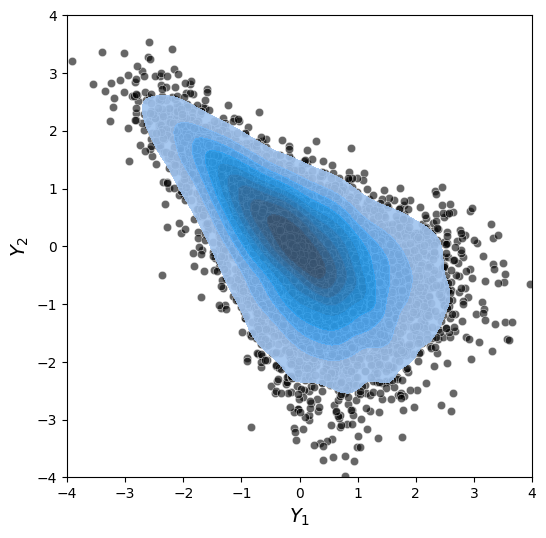

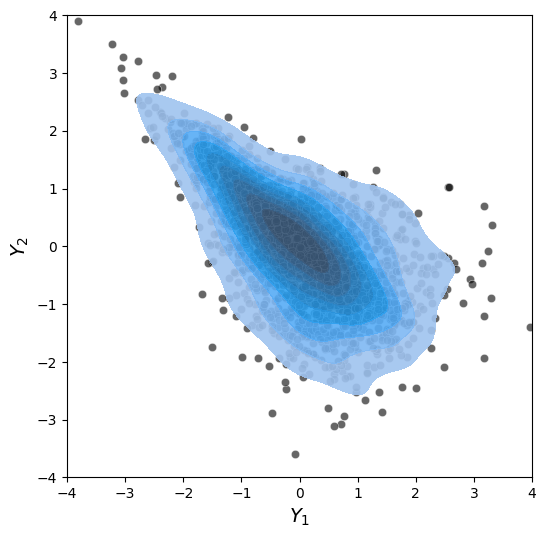

In [17]:
model.plot_densities(synthetic_samples, x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

The varying pseudo conditional correlation matrix values can be computed for any synthetic samples using `compute_pseudo_conditional_correlation_matrix` or can directly be plotted using `plot_conditional_dependence_structure`.
The pseudo conditional correlation matrix is the standardised precision matrix so that off diagonal elements are the pseudo conditional correlations between the respective dimensions.

In [18]:
pseudo_conditional_correlation_matrix = model.compute_pseudo_conditional_correlation_matrix(synthetic_samples)

/Users/franciscocapunay/miniforge3/envs/gtm-general/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/franciscocapunay/miniforge3/envs/gtm-general/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


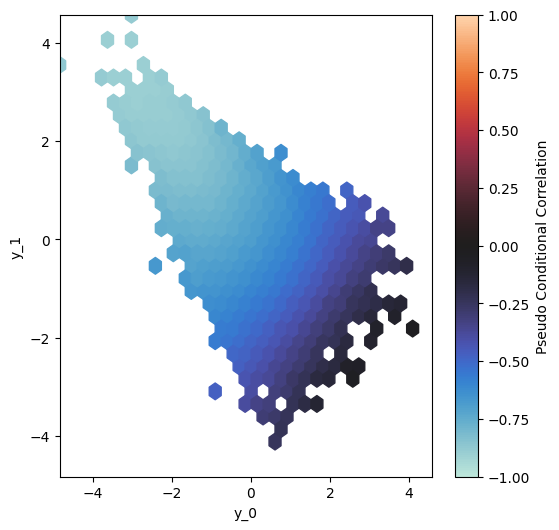

In [19]:
model.plot_conditional_dependence_structure(data=synthetic_samples)

One can also visualize the splines of each layer usign the function `plot_splines`. For the transformation layer we additionally include the dervaitive which is always positive due to the monotonically increasing constraint as well as the inverse which should lie exactly on the spline to visually confirm that the inverse sampling path works.

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


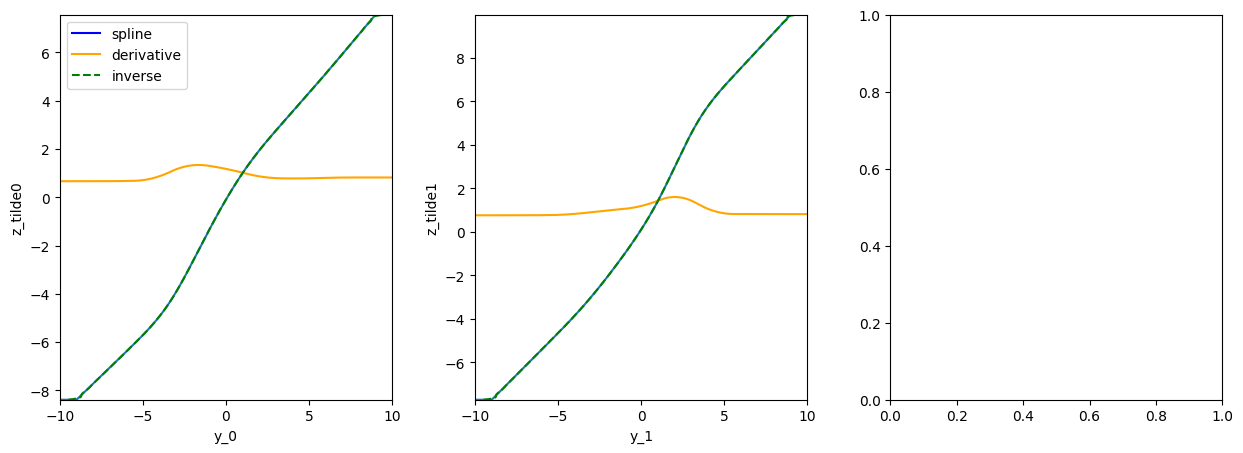

In [20]:
model.plot_splines(layer_type="transformation")

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


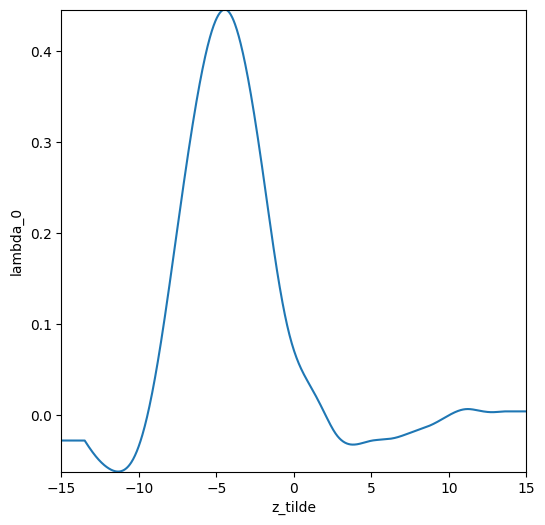

In [21]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


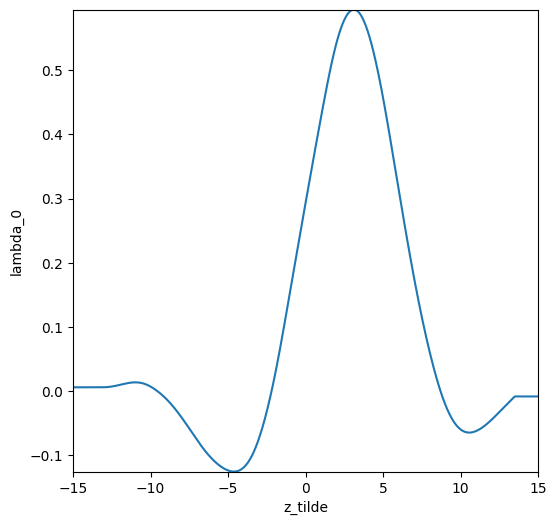

In [22]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


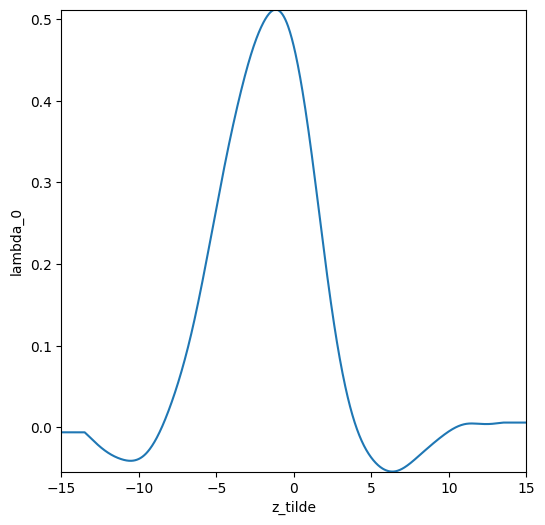

In [23]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)